In [ ]:
# Load library
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import h5py
import time
from sklearn import multioutput
import xgboost as xgb

In [ ]:
# Seed
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759


In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759/Data')
Data1 = loadmat('p5759_Inputs.mat')
Data2 = loadmat('p5759_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['K','V','AE','Amp','SS','TTF']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
                 K      V     AE       Amp
0      3511910.82  23.33   1.50  12313.25
1      3511805.49  23.16   1.67  12390.65
2         3807.30  16.44   1.67  12433.71
3          992.68  16.27   1.33  12425.59
4          999.61  16.27   1.33  12417.39
...           ...    ...    ...       ...
2549  46495304.45  57.63  21.00  14054.81
2550  28519703.48  45.56  28.00  14150.11
2551  28519724.49  45.56  26.67  14268.53
2552  28519838.19  45.57   8.67  14322.32
2553  28519979.30  45.56   2.00  14373.05

[2554 rows x 4 columns]
Target Data:
          SS   TTF
0     11.43  0.00
1     11.46  5.78
2     11.54  5.67
3     11.65  5.56
4     11.73  5.46
...     ...   ...
2549  12.79  0.00
2550  11.50  0.00
2551  11.33  0.00
2552  11.41  0.00
2553  11.52  0.00

[2554 rows x 2 columns]


In [ ]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix, -2:]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Preprocessing
arr = df.to_numpy()
n_steps = 100
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (2454, 100, 4)
Target shape, Y =  (2454, 2)
After reshaping, X =  (2454, 400)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state = 0, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state = 0, test_size=0.125, shuffle=False)

# # Select Train
X_train = X_train[1226:1717]
Y_train = Y_train[1226:1717]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples:", np.shape(Y_train))
print("Validation output samples:", np.shape(Y_val))
print("Testing output samples:", np.shape(y_test))

Training input samples: (491, 400)
Validation input samples: (246, 400)
Testing input samples: (491, 400)
Training output samples: (491, 2)
Validation output samples: (246, 2)
Testing output samples: (491, 2)


In [ ]:
# Train the model
model = XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=600)
model = multioutput.MultiOutputRegressor(model)
start_time = time.time()
model.fit(X_train, Y_train, verbose=True)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

---Training time: 46.42509913 seconds ---


In [ ]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))

ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[0]))

ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[1]))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))

ss_val_r2 = r2_score(Y_val[:,0], y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[0]))

ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[1]))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ss_test_r2 = r2_score(y_test[:,0], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[0]))

ttf_test_r2 = r2_score(y_test[:,1], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[1]))

## Print
print('Shear Stress')
print('R2 score:', ss_train_r2, ss_val_r2 ,ss_test_r2, '\nRMSE:', ss_train_rmse, ss_val_rmse ,ss_test_rmse)
print('\nTTF')
print('R2 score:', ttf_train_r2, ttf_val_r2, ttf_test_r2, '\nRMSE:', ttf_train_rmse, ttf_val_rmse , ttf_test_rmse)

Shear Stress
R2 score: 0.9999975230416815 0.8640939593817193 0.6333887566316629 
RMSE: 0.0005574796008555444 0.13731439668421447 0.2336479133455038

TTF
R2 score: 0.9999999012311067 0.7434600467422261 0.553762473064492 
RMSE: 0.0006059746830932548 1.0313515629264847 1.3672587804064167


Text(0.5, 1.0, 'XGBoost: Shear Stress Prediction')

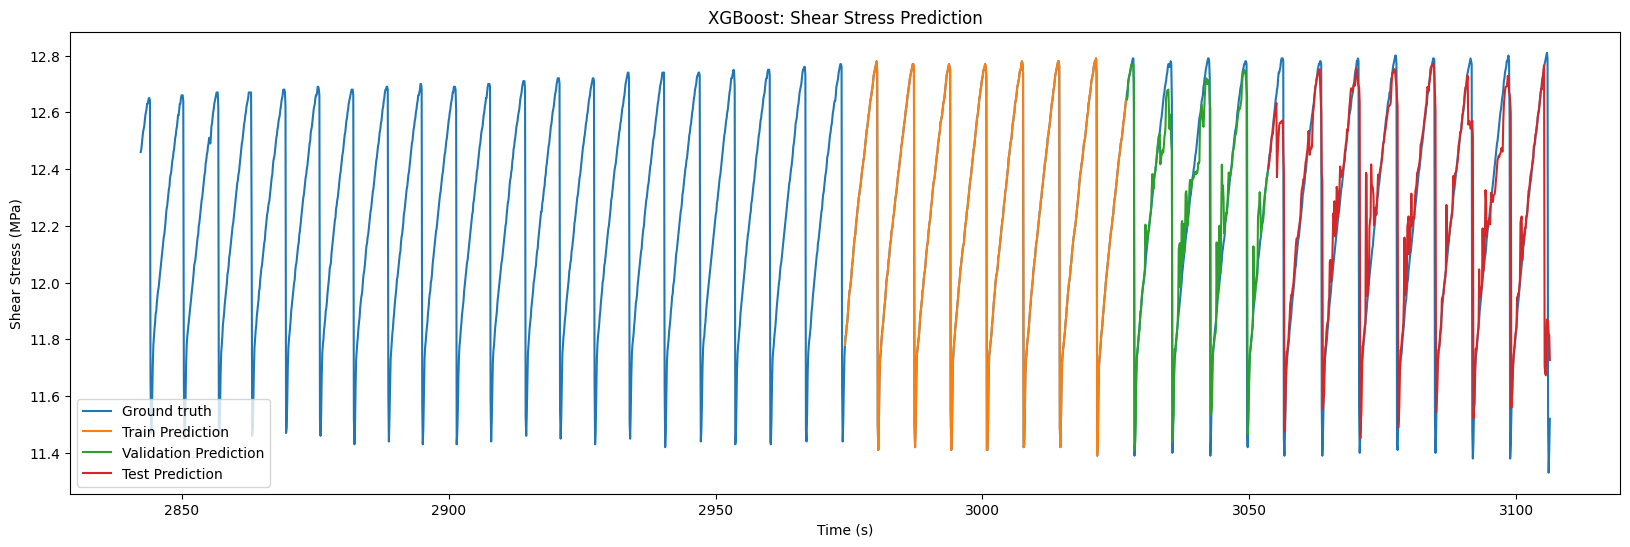

In [ ]:
# Overall plot: SS
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[1226:1717]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf[:,0])
plt.plot(traintime, y_predTrain.iloc[:,0])
plt.plot(valtime, y_predVal.iloc[:,0])
plt.plot(testtime, y_predTest.iloc[:,0])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Shear Stress Prediction')

Text(0.5, 1.0, 'XGBoost: TTF Prediction')

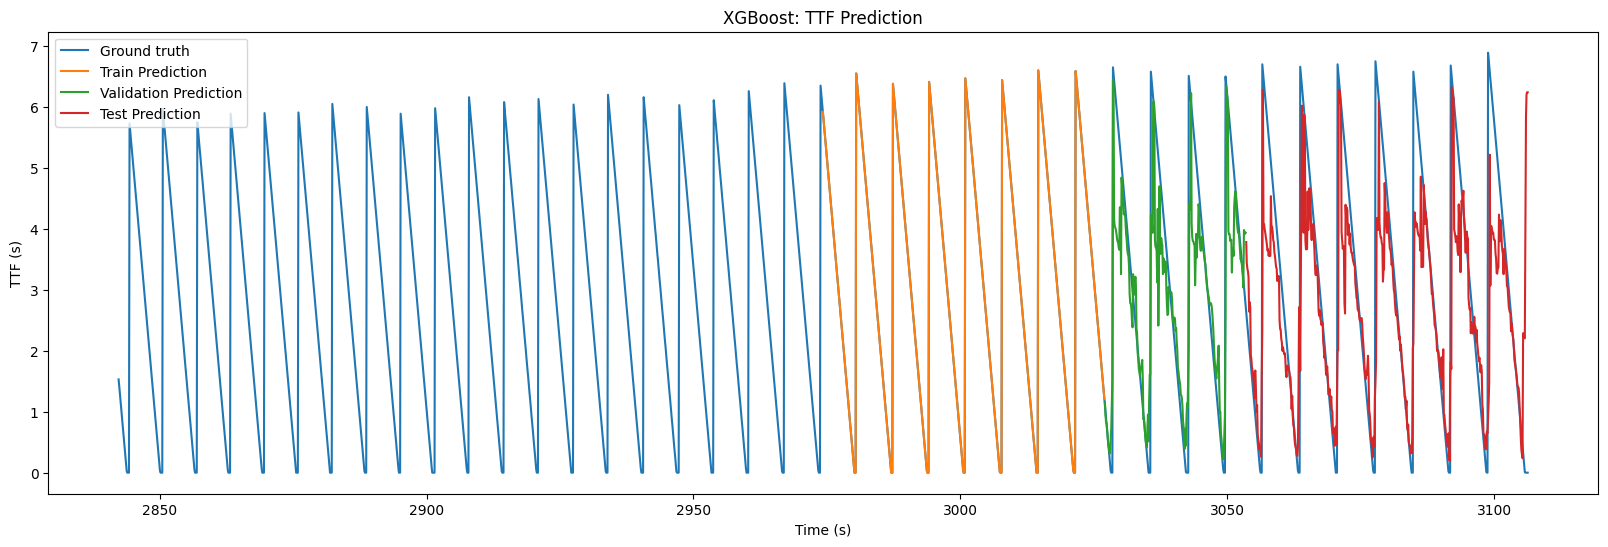

In [ ]:
# Overall plot: TTF
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[1226:1717]

## TTF
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf[:,1])
plt.plot(traintime, y_predTrain.iloc[:,1])
plt.plot(valtime, y_predVal.iloc[:,1])
plt.plot(testtime, y_predTest.iloc[:,1])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: TTF Prediction')

In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759/Data')
Data1 = loadmat('p5759_Inputs.mat')
Data2 = loadmat('p5759_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['AE','ln_V_V0']]
xdf = df[['AE']]
ydf = df[['ln_V_V0']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
          AE
0      1.50
1      1.67
2      1.67
3      1.33
4      1.33
...     ...
2549  21.00
2550  28.00
2551  26.67
2552   8.67
2553   2.00

[2554 rows x 1 columns]
Target Data:
       ln_V_V0
0      -11.51
1      -11.51
2      -11.51
3      -11.51
4      -11.51
...       ...
2549   -11.51
2550     1.45
2551   -11.51
2552   -11.51
2553   -11.51

[2554 rows x 1 columns]


In [ ]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1:]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Preprocessing
arr = df.to_numpy()
n_steps = 100
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (2454, 100, 1)
Target shape, Y =  (2454, 1)
After reshaping, X =  (2454, 100)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state = 0, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state = 0, test_size=0.125, shuffle=False)

# # Select Train
X_train = X_train[1226:1717]
Y_train = Y_train[1226:1717]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples:", np.shape(Y_train))
print("Validation output samples:", np.shape(Y_val))
print("Testing output samples:", np.shape(y_test))

Training input samples: (491, 100)
Validation input samples: (246, 100)
Testing input samples: (491, 100)
Training output samples: (491, 1)
Validation output samples: (246, 1)
Testing output samples: (491, 1)


In [ ]:
# Train the model
model = XGBRegressor(learning_rate=0.1, max_depth=6, n_estimators=600)
model = multioutput.MultiOutputRegressor(model)
start_time = time.time()
model.fit(X_train, Y_train, verbose=True)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

---Training time: 0.50515628 seconds ---


In [ ]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))
sr_train_r2 = r2_score(Y_train, y_predTrain)
sr_train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))
sr_val_r2 = r2_score(Y_val, y_predVal)
sr_val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))
sr_test_r2 = r2_score(y_test, y_predTest)
sr_test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

## Print
print('\nSlip rate')
print('R2 score:', sr_train_r2, sr_val_r2, sr_test_r2, '\nRMSE:', sr_train_rmse, sr_val_rmse , sr_test_rmse)


Slip rate
R2 score: 0.9999999909317309 0.9234882856937855 0.5663873922107268 
RMSE: 0.00014723994782273617 0.4573263720596268 1.1285341515693252


Text(0.5, 1.0, 'XGBoost: Slip Rate Prediction')

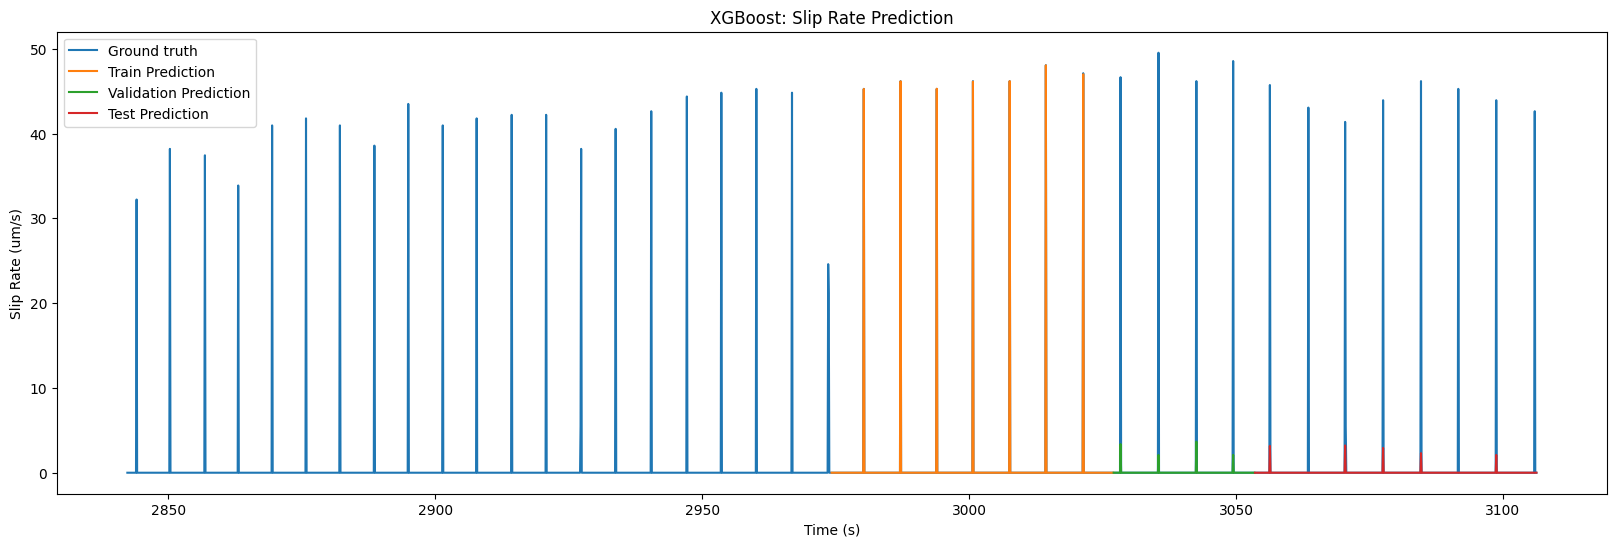

In [ ]:
# Overall plot: Slip Rate
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[1226:1717]

# Scale
ydf_scale = ydf
ydf_scale = np.exp(ydf_scale)*10;

y_predTrain_scale = y_predTrain
y_predTrain_scale = np.exp(y_predTrain_scale)*10;

y_predVal_scale = y_predVal
y_predVal_scale = np.exp(y_predVal_scale)*10;

y_predTest_scale = y_predTest
y_predTest_scale = np.exp(y_predTest_scale)*10;

## SR
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_scale)
plt.plot(traintime, y_predTrain_scale)
plt.plot(valtime, y_predVal_scale)
plt.plot(testtime, y_predTest_scale)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Slip Rate Prediction')